In [37]:
import torch
import pyro
import pyro.distributions as dist
from pyro.ops.indexing import Vindex
from pyro import poutine
import matplotlib.pyplot as plt
import torch.distributions.constraints as constraints
from torch.distributions import transform_to
from pyro.infer import MCMC, NUTS
from pyro.poutine.messenger import Messenger


### Index:

0. [**Definitions**](#Definitions:)
    How pyro learn the model parameters in the guide by comparing both with use of the evidence lower bound (elbo).  

1. [**Conditionaly-independet-elbo**](#Conditionaly-independet-elbo::)<br>
    Interpretation of batch in pyro (what the plate and it log means)
    
2. [**First example with hso**](#hso0:)<br>
    The *hierarchical sparse observable* first example here


### Definitions:
([1]- http://pyro.ai/examples/svi_part_i.html)

The model has the **observable** x and latent random variables z and parameters $\theta$
and the goal is to maximize the log evidence $log \ p_{\theta}(x)$ i.e. to find $\theta_{max} = argmax_{\theta} \ log \ p_{\theta}(x)$ 
where $p_{\theta}(x)= log \int p_{\theta}(x, z) d z$,
with use of the guide.

Since it is generaly hard to solve this problem, and since they also want to find the posterior:
<br>$p_{\theta_{max}}(z|\ x)=\frac{p_{\theta_max}(x, z)}{\int p_{\theta_{max}}(x, z) d z}$

so for solving this problem the guide used i.e. the model $q_{\phi}(z)$ with some parameters $\phi$ as approximation for the $\theta$.

Then, the *"goal will be to find the (not necessarily unique) probability distribution in that space that is the best possible approximation to the posterior distribution." [1]*


This done by use of the elbo:
<br>$elbo = E_{q_{\phi}(z)}[log p_{\theta}(x, z)-log q_{\phi}(z)]$
<br>And then use the fact that the elbo is a lower bound of the log evidence i.e.:
<br>$log \ p_{theta}(x)>elbo$
<br>and so *" if we take (stochastic) gradient steps to maximize the ELBO, we will also be pushing the log evidence higher (in expectation)" [1]*

### Conditionaly independet `elbo`:
(REF: http://pyro.ai/examples/svi_part_ii.html#The-Goal:-Scaling-SVI-to-Large-Datasets)

For example, in the case that the observations are conditionally independent given the latents, the log likelihood **term** in the ELBO (i.e. in $E_{q_{\phi}(z)}[term]$ or rather $E{q_{\phi}(z)}[term(p)-term(q)]$) can be approximated with
    $\sum_{1,...,N}log \ p(x_{i}|\ z) \approx N/M\sum_{i\in I_{M}} log \ p(x_{i}|\ z)$ 
where $I_{M}$ is a mini-batch of indexes of size M with M < N
so in the code like:


In [2]:
pyro.clear_param_store()
def model_test():
    with pyro.plate("data_loop", size=3):
        box = pyro.sample("box", dist.Uniform(0.1, 0.3))
        print("box", box)
        print("log inside plate:", dist.Uniform(0.1, 0.3).log_prob(box))
trace = poutine.trace(model_test).get_trace()
trace.log_prob_sum()

box tensor([0.2761, 0.2731, 0.2889])
log inside plate: tensor([1.6094, 1.6094, 1.6094])


tensor(4.8283)

will return only one dim value (tensor(16.0944)) and print many dim box and its log.


### Some dist:

/home/valdecar/anaconda3/envs/math/lib/python3.6/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


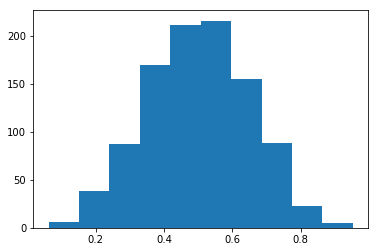

In [178]:
plt.hist(dist.Beta(5, 5).sample_n(1000))
plt.show()

/home/valdecar/anaconda3/envs/math/lib/python3.6/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


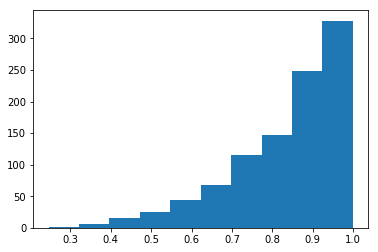

In [180]:
plt.hist(dist.Beta(5, 1).sample_n(1000))
plt.show()

/home/valdecar/anaconda3/envs/math/lib/python3.6/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


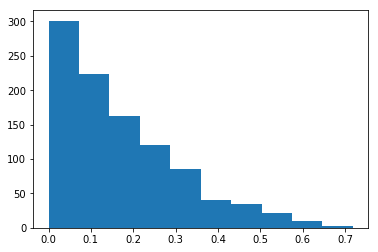

In [183]:
plt.hist(dist.Beta(1, 5).sample_n(1000))
plt.show()

### Global params:
Now, if we introduce the params $\lambda_{i}$ here, they will be independent, according to
<br>$p(x, z, \beta)=p(\beta) \prod_{i=1...N}p(x_{i}|z_{i})p(z_{i}|\beta)$
<br>for the model and:
<br>$q(z, \beta)=q(\beta) \prod_{i=1...N}q(z_{i}|\beta,\lambda_{i})$
<br>for the quide. There is also the param $\beta$ which is a global one.

In [153]:
z_alpha_orig = 0.1
beta_beta_orig = 0.9

def model_test1(obs=None, size=3, dbg=True):
    if dbg:
        print("\nfrom model test1\n")
    beta = pyro.sample("beta", dist.Uniform(0.3, beta_beta_orig))
    if dbg:
        print("beta:", beta)
    with pyro.plate("data_loop", size=size) as ind:
        zdist = dist.Uniform(z_alpha_orig, beta)
            
        z_i = pyro.sample("z_i", zdist)
        if dbg:
            print("z_i", z_i)
            print("zdist.log_prob(z_i):", zdist.log_prob(z_i))
        if obs is not None:
            x_i = pyro.sample("x_i", dist.Bernoulli(z_i), obs=obs.index_select(0, ind))
        else:
            x_i = pyro.sample("x_i", dist.Bernoulli(z_i))
    return x_i

def guide_test1(obs=None, size=3, dbg=True):
    '''beta is a global variable while lambda_i is local one.
    b is the high bound of the betta and restricted in interval (0.3, 0.9)
        beta restricted in interval (0.3, b)
    while l_i is the low bound of the lambda_i and restricted in interval (0.1, 0.3)
        lambda_i restricted in interval (l_i, 0.3)
        
    both lambda_i and beta used as parameters of the z varialbe'''
    
    if dbg:
        print("\nfrom guide test1\n")
    b = pyro.param("b", torch.tensor(0.8), constraint=constraints.interval(0.3, 0.9))
    beta_dist = dist.Uniform(0.3, b)
    beta = pyro.sample("beta", beta_dist)
    if dbg:
        print("beta", beta)
    with pyro.plate("data_loop", size=size):
        l_i = pyro.param("l_i", torch.tensor(0.2), constraint=constraints.interval(0.1, 0.3))
        lambda_i_dist = dist.Uniform(l_i, 0.3)
        lambda_i = pyro.sample("lambda_i", lambda_i_dist)
        if dbg:
             print("lambda_i", lambda_i)
        # zdist = dist.Uniform(0.1, beta)
        zdist = dist.Uniform(lambda_i, beta)
        z_i = pyro.sample("z_i", zdist)
        if dbg:
            print("z_i", z_i)
            print("zdist.log_prob(z_i):", zdist.log_prob(z_i))

##### Check for the `log_prob_sum` is not  `-inf`

In [171]:
pyro.clear_param_store()
guide_trace1 = poutine.trace(guide_test1).get_trace()
replayed_model1 = poutine.replay(model_test1, trace=guide_trace1)
rmodel_trace1 = poutine.trace(replayed_model1).get_trace()

print("\nfrom replayed model:\n")
print("beta: ", rmodel_trace1.nodes["beta"]["value"])
print("z_i: ", rmodel_trace1.nodes["z_i"]["value"])

print("\nfrom quide model:\n")
print("beta: ", guide_trace1.nodes["beta"]["value"])
# print("z_i: ", guide_trace1.nodes["z_i"]["value"])
rmodel_trace1.log_prob_sum()


from guide test1

beta tensor(0.3750, grad_fn=<AddBackward0>)
lambda_i tensor([0.2707, 0.2312, 0.2601], grad_fn=<AddBackward0>)
z_i tensor([0.3491, 0.2445, 0.2899], grad_fn=<AddBackward0>)
zdist.log_prob(z_i): tensor([2.2606, 1.9391, 2.1633], grad_fn=<SubBackward0>)

from model test1

beta: tensor(0.3750, grad_fn=<AddBackward0>)
z_i tensor([0.3491, 0.2445, 0.2899], grad_fn=<AddBackward0>)
zdist.log_prob(z_i): tensor([1.2909, 1.2909, 1.2909], grad_fn=<SubBackward0>)

from replayed model:

beta:  tensor(0.3750, grad_fn=<AddBackward0>)
z_i:  tensor([0.3491, 0.2445, 0.2899], grad_fn=<AddBackward0>)

from quide model:

beta:  tensor(0.3750, grad_fn=<AddBackward0>)


tensor(3.3314, grad_fn=<AddBackward0>)

In [107]:
obs = model_test1(None, 100, dbg=False)

All what been sampled in pyro `plate` will be sum up to one dim in the `log_prob_sum`:

In [163]:
pyro.clear_param_store()
obs = model_test1(None, 10, dbg=False)
trace = poutine.trace(model_test1).get_trace(obs, 10)
trace.log_prob_sum()


from model test1

beta: tensor(0.7651)
z_i tensor([0.5843, 0.4550, 0.5983, 0.2682, 0.4394, 0.7256, 0.5950, 0.5728, 0.6850,
        0.5809])
zdist.log_prob(z_i): tensor([0.4078, 0.4078, 0.4078, 0.4078, 0.4078, 0.4078, 0.4078, 0.4078, 0.4078,
        0.4078])


tensor(-3.6258)

This sum is equal to<br>
$log \ p_{\theta}(x, z)-log \ q_{\phi}(z)$<br>


it will be used in calculation of the `elbo` by the code:
    

In [59]:
'''
        elbo = 0.0
        for model_trace, guide_trace in self._get_traces(model, guide, args, kwargs):
            elbo_particle = torch_item(model_trace.log_prob_sum()) - torch_item(guide_trace.log_prob_sum())
            elbo += elbo_particle / self.num_particles
'''
# REF: `loss` method of the `Trace_ELBO` in `pyro/infer/trace_elbo.py`

'\n        elbo = 0.0\n        for model_trace, guide_trace in self._get_traces(model, guide, args, kwargs):\n            elbo_particle = torch_item(model_trace.log_prob_sum()) - torch_item(guide_trace.log_prob_sum())\n            elbo += elbo_particle / self.num_particles\n'

In [172]:
def train(model, guide, obs, num_steps=500, a_name="l_i"):
    # setup the optimizer:
    adam_params = {"lr": 0.05, "betas": (0.9, 0.999)}
    optimizer = pyro.optim.Adam(adam_params)

    loss = pyro.infer.Trace_ELBO()
    # optimizer.zero_grad()
    pyro.clear_param_store()

    svi = pyro.infer.SVI(model=model,
                         guide=guide,
                         # guide=coin_parametrized_guide,
                         optim=optimizer,
                         loss=loss)


    losses, a,b  = [], [], []
    # num_steps = 500  # 2500
    for t in range(num_steps):
        # import pdb; pdb.set_trace()
        losses.append(svi.step(obs, size=len(obs), dbg=False))
        a.append(pyro.param(a_name).item())
        b.append(pyro.param("b").item())
        # print(pyro.param("a").grad)
    return losses, a, b

### Learning:


/home/valdecar/anaconda3/envs/math/lib/python3.6/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 8000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


100
a:  0.1099330335855484
b:  0.4000000059604645
a =  0.1099330335855484
b =  0.4000000059604645

originals:
z_alpha_orig:  0.1
beta_beta_orig:  0.9


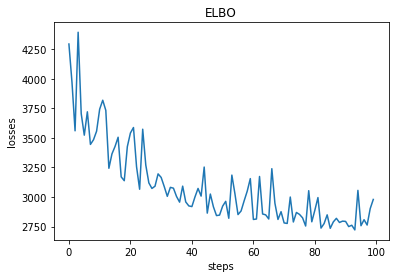

In [173]:
pyro.clear_param_store()
obs = model_test1(None, 1000, dbg=False)
pyro.clear_param_store()
losses, a, b = train(model_test1, guide_test1, obs, num_steps=100)
print(len(b))
# is't last Nan?:
print("a: ", a[-1])
print("b: ", b[-1])
# losses
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("steps")
plt.ylabel("losses");
print('a = ',pyro.param("l_i").item())
print('b = ',pyro.param("b").item())
print("\noriginals:")
print("z_alpha_orig: ", z_alpha_orig)
print("beta_beta_orig: ", beta_beta_orig)

plt.show()
# print("losses:", loss)

### The same model but with iteration:

In [119]:
z_alpha_orig = 0.1
beta_beta_orig = 0.9


def model_test2(obs=None, size=3, dbg=True):
                
    if dbg:
        print("\nfrom model test2\n")
    beta = pyro.sample("beta", dist.Uniform(0.3, beta_beta_orig))

    if dbg:
        print("beta:", beta)
    xs = []
    for i in pyro.plate("data_loop", size=size):
        zdist = dist.Uniform(z_alpha_orig, beta)
        z_i = pyro.sample("z_%s"%str(i), zdist)
        if dbg:
            print("z_%s"%str(i), z_i)
            print("zdist.log_prob(z_%s):"%str(i), zdist.log_prob(z_i))
        if obs is not None:
            x_i = pyro.sample("x_%s" % str(i), dist.Bernoulli(z_i), obs=obs[i])
        else:
            x_i = pyro.sample("x_%s" % str(i), dist.Bernoulli(z_i))
            xs.append(x_i)
    return xs

         
def guide_test2(obs=None, size=3, dbg=True):
    '''beta is a global variable while lambda_i is local one.
    b is the high bound of the betta and restricted in interval (0.3, 0.9)
        beta restricted in interval (0.3, b)
    while l_i is the low bound of the lambda_i and restricted in interval (0.1, 0.3)
        lambda_i restricted in interval (l_i, 0.3)
        
    both lambda_i and beta used as parameters of the z varialbe'''
    
    if dbg:
        print("\nfrom guide test2\n")
 
    b = pyro.param("b", torch.tensor(0.8), constraint=constraints.interval(0.3, 0.9))
    beta_dist = dist.Uniform(0.3, b)
    beta = pyro.sample("beta", beta_dist)
    if dbg:
        print("beta", beta)

    for i in pyro.plate("data_loop", size=size):
        l_i = pyro.param("l_%s"%str(i), torch.tensor(0.2),
                         constraint=constraints.interval(0.1, 0.3))
        lambda_i_dist = dist.Uniform(l_i, 0.3)
        lambda_i = pyro.sample("lambda_%s"%str(i), lambda_i_dist)
        if dbg:
            print("lambda_i", lambda_i)
    
        zdist = dist.Uniform(lambda_i, beta)
        z_i = pyro.sample("z_%s"%str(i), zdist)
        if dbg:
            print("z_i", z_i)
            print("zdist.log_prob(z_i):", zdist.log_prob(z_i))
     

##### Check for the `log_prob_sum` is not  `-inf`

In [120]:
pyro.clear_param_store()
guide_trace2 = poutine.trace(guide_test2).get_trace()
replayed_model2 = poutine.replay(model_test2, trace=guide_trace2)
rmodel_trace2 = poutine.trace(replayed_model2).get_trace()

print("\nfrom replayed model:\n")
print("beta: ", rmodel_trace2.nodes["beta"]["value"])
print("z_2: ", rmodel_trace2.nodes["z_2"]["value"])

print("\nfrom quide model:\n")
print("beta: ", guide_trace2.nodes["beta"]["value"])
print("z_2: ", guide_trace2.nodes["z_2"]["value"])
rmodel_trace2.log_prob_sum()


from guide test2

beta tensor(0.7022, grad_fn=<AddBackward0>)
lambda_i tensor(0.2441, grad_fn=<AddBackward0>)
z_i tensor(0.3685, grad_fn=<AddBackward0>)
zdist.log_prob(z_i): tensor(0.7808, grad_fn=<SubBackward0>)
lambda_i tensor(0.2563, grad_fn=<AddBackward0>)
z_i tensor(0.6694, grad_fn=<AddBackward0>)
zdist.log_prob(z_i): tensor(0.8076, grad_fn=<SubBackward0>)
lambda_i tensor(0.2923, grad_fn=<AddBackward0>)
z_i tensor(0.5695, grad_fn=<AddBackward0>)
zdist.log_prob(z_i): tensor(0.8918, grad_fn=<SubBackward0>)

from model test2

beta: tensor(0.7022, grad_fn=<AddBackward0>)
z_0 tensor(0.3685, grad_fn=<AddBackward0>)
zdist.log_prob(z_0): tensor(0.5072, grad_fn=<SubBackward0>)
z_1 tensor(0.6694, grad_fn=<AddBackward0>)
zdist.log_prob(z_1): tensor(0.5072, grad_fn=<SubBackward0>)
z_2 tensor(0.5695, grad_fn=<AddBackward0>)
zdist.log_prob(z_2): tensor(0.5072, grad_fn=<SubBackward0>)

from replayed model:

beta:  tensor(0.7022, grad_fn=<AddBackward0>)
z_2:  tensor(0.5695, grad_fn=<AddBackward0

tensor(0.0696, grad_fn=<AddBackward0>)

### Learning:
(much slower)

100
a:  0.10931509733200073
b:  0.8847571015357971
a =  0.10931509733200073
b =  0.8847571015357971

originals:
z_alpha_orig:  0.1
beta_beta_orig:  0.9


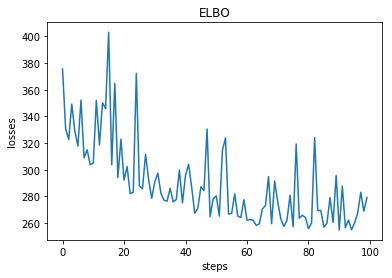

In [124]:
pyro.clear_param_store()
obs = model_test2(None, 100, dbg=False)
pyro.clear_param_store()
losses, a, b = train(model_test2, guide_test2, obs, num_steps=100,a_name="l_2")
print(len(b))
# is't last Nan?:
print("a: ", a[-1])
print("b: ", b[-1])
# losses
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("steps")
plt.ylabel("losses");
print('a = ',pyro.param("l_2").item())
print('b = ',pyro.param("b").item())
print("\noriginals:")
print("z_alpha_orig: ", z_alpha_orig)
print("beta_beta_orig: ", beta_beta_orig)

plt.show()
# print("losses:", loss)

In [125]:
guide_trace2 = poutine.trace(guide_test2).get_trace()
replayed_model2 = poutine.replay(model_test1, trace=guide_trace2)


from guide test2

beta tensor(0.5189, grad_fn=<AddBackward0>)
lambda_i tensor(0.1139, grad_fn=<AddBackward0>)
z_i tensor(0.2074, grad_fn=<AddBackward0>)
zdist.log_prob(z_i): tensor(0.9040, grad_fn=<SubBackward0>)
lambda_i tensor(0.2986, grad_fn=<AddBackward0>)
z_i tensor(0.3474, grad_fn=<AddBackward0>)
zdist.log_prob(z_i): tensor(1.5127, grad_fn=<SubBackward0>)
lambda_i tensor(0.1954, grad_fn=<AddBackward0>)
z_i tensor(0.2649, grad_fn=<AddBackward0>)
zdist.log_prob(z_i): tensor(1.1286, grad_fn=<SubBackward0>)


### hso0:

##### The condition:
(and also obs gen, if obs is not given)

In [3]:
box_param_a = 1
box_param_b = 5
# data = torch.zeros(10)
# data[0:6] = torch.ones(6)

# condition0
def conditioned_coin_obs(obs_flips, obs_coins, size=170, dbg=True):
    # print("conditioned guess:",guess)
    # coin_param_dist = dist.Uniform(0.1, 0.9)
    # coin_param = coin_param_dist.sample()
    # print("coin param: ", coin_param)
    if dbg:
       print("\nfrom conditioned_coin_obs\n")
    
    coins=[]
    flips=[]
    # bug here with Uniform(0, 1)
    # coin = pyro.sample("coin", dist.Uniform(0, 2))
    # print("conditioned: coin: ", coin)
    # sample 10 times:
    with pyro.plate("data_loop", size=size) as ind:
        # no matter what, this value will be
        # replaced by the guide (get_trace(guide).nodes["coin"]["value"])
        box_dist = dist.Beta(box_param_a, box_param_b)
        box = pyro.sample("box", box_dist)

        if dbg:
            print("box", box)
            print("log box", box_dist.log_prob(box))
            # print("box_dist.batch_shape", box_dist.batch_shape)
            # print("coin_dist.batch_shape", coin_dist.batch_shape)
          
        coin_dist = dist.Beta(5, 10.*box)
        
        if obs_coins is not None:
            coin = pyro.sample("coin", coin_dist,
                               obs=obs_coins.index_select(0, ind))
        else:
            coin = pyro.sample("coin", coin_dist)
            coins.append(coin)
            if dbg:
                print("coin:", coin)
                print("coin log_prob:", coin_dist.log_prob(coin))
        
        flip_dist = dist.Bernoulli(probs=coin)
       
        if obs_flips is not None:
            flip = pyro.sample("flip", flip_dist,
                               obs=obs_flips.index_select(0, ind))
        else:
            flip = pyro.sample("flip", flip_dist)
            flips.append(flip)
            if dbg:
                print("flip:", flip)
                print("flip log_prob:", flip_dist.log_prob(flip))
        
    return(torch.cat(flips, 0) if flips != [] else None,
           torch.cat(coins, 0) if coins != [] else None)

In [4]:
# data = torch.tensor([coin_model0(1) for i in range(10)])
# data
pyro.clear_param_store()
obs_flips, obs_coins = conditioned_coin_obs(None, None, size=3)
print("obs_coins:", obs_coins)
print("obs_flips:", obs_flips)


from conditioned_coin_obs

box tensor([0.2867, 0.0834, 0.0900])
log box tensor([0.2579, 1.2609, 1.2323])
coin: tensor([0.6465, 0.9725, 0.9768])
coin log_prob: tensor([0.8201, 1.6927, 1.6559])
flip: tensor([1., 1., 1.])
flip log_prob: tensor([-0.4362, -0.0279, -0.0235])
obs_coins: tensor([0.6465, 0.9725, 0.9768])
obs_flips: tensor([1., 1., 1.])


##### bug with log_prob

In [203]:
pyro.clear_param_store()
obs_flips, obs_coins = conditioned_coin_obs(None, None, size=3)
# trace = poutine.trace(conditioned_coin_obs).get_trace(None, None, size=3)
print("obs_flips:", obs_flips)
print("obs_coins:", obs_coins)
trace = poutine.trace(conditioned_coin_obs).get_trace(obs_flips, obs_coins, size=3)
print("log_prob_sum()", trace.log_prob_sum())
# print("\nnode box", trace.nodes['box'])
# print("\nnode coin", trace.nodes['coin'])
# print("\nnode flip", trace.nodes['flip'])
# print("coin dist.low:", trace.nodes['coin']['fn'].low)
# print("coin dist.high:", trace.nodes['coin']['fn'].high)



from conditioned_coin_obs

box tensor([0.1819, 0.3065, 0.0913])
log box tensor([0.8063, 0.1456, 1.2266])
coin: tensor([0.7412, 0.5874, 0.9694])
coin log_prob: tensor([0.8253, 0.7681, 1.5845])
flip: tensor([1., 1., 1.])
flip log_prob: tensor([-0.2995, -0.5320, -0.0311])
obs_flips: tensor([1., 1., 1.])
obs_coins: tensor([0.7412, 0.5874, 0.9694])

from conditioned_coin_obs

box tensor([0.1378, 0.7135, 0.1237])
log box tensor([ 1.0166, -3.3904,  1.0813])
log_prob_sum() tensor(-0.0538)


#### Some `pyro.plate` working:

In [195]:
box = pyro.sample("box", dist.Uniform(0.1*torch.ones((3,3)), 0.3*torch.ones((3,3))))
print("box", box)
print(dist.Uniform(0.1, 0.3).log_prob(box))

box tensor([[0.1581, 0.2835, 0.1318],
        [0.1816, 0.1526, 0.2539],
        [0.1411, 0.1976, 0.1280]])
tensor([[1.6094, 1.6094, 1.6094],
        [1.6094, 1.6094, 1.6094],
        [1.6094, 1.6094, 1.6094]])


In [196]:
with pyro.plate("data_loop", size=10):
    box = pyro.sample("box", dist.Uniform(0.1, 0.3))
    print("box", box)
    print("log inside plate:", dist.Uniform(0.1, 0.3).log_prob(box))
print("log outside plate:", dist.Uniform(0.1, 0.3).log_prob(box))


box tensor([0.2390, 0.2883, 0.2892, 0.1182, 0.1680, 0.1401, 0.1665, 0.2393, 0.1177,
        0.2820])
log inside plate: tensor([1.6094, 1.6094, 1.6094, 1.6094, 1.6094, 1.6094, 1.6094, 1.6094, 1.6094,
        1.6094])
log outside plate: tensor([1.6094, 1.6094, 1.6094, 1.6094, 1.6094, 1.6094, 1.6094, 1.6094, 1.6094,
        1.6094])


In [16]:
pyro.clear_param_store()
conditioned_coin_obs(obs_coin_flips, obs_coins, size=30)

box_dist.batch_shape torch.Size([])
coin_dist.batch_shape torch.Size([30])


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.])

### guide:

In [5]:
def coin_parametrized_guide(obs_flips, obs_coins=None, size=None, dbg=True):
   
    aa = pyro.param("a", torch.tensor(3),
                    constraint=constraints.interval(1, 10))
    bb = pyro.param("b", torch.tensor(3),
                    constraint=constraints.interval(1, 10))
    # print("guide a:", aa)
    with pyro.plate("data_loop", size=size):
        res = pyro.sample("box", dist.Beta(aa, bb))
    # print("guide: res", res.shape)
    return res

##### Check for the `log_prob_sum` is not  `-inf`

In [211]:
obs_flips, obs_coins = conditioned_coin_obs(None, None, size=3)
pyro.clear_param_store()
guide_trace_coin = poutine.trace(coin_parametrized_guide).get_trace(obs_flips, obs_coins, size=3)
replayed_model_coin = poutine.replay(conditioned_coin_obs, trace=guide_trace_coin)
rmodel_trace_coin = poutine.trace(replayed_model_coin).get_trace(obs_flips, obs_coins, size=3)

print("\nfrom replayed model:\n")
print("beta: ", rmodel_trace_coin.nodes["box"]["value"])
print("coin: ", rmodel_trace_coin.nodes["coin"]["value"])
print("flip: ", rmodel_trace_coin.nodes["flip"]["value"])

print("\nfrom quide model:\n")

rmodel_trace_coin.log_prob_sum()


from conditioned_coin_obs

box tensor([0.1829, 0.0340, 0.0816])
log box tensor([0.8014, 1.4709, 1.2690])
coin: tensor([0.7290, 0.9905, 0.8481])
coin log_prob: tensor([0.7991, 2.5982, 0.8494])
flip: tensor([1., 1., 1.])
flip log_prob: tensor([-0.3161, -0.0095, -0.1647])

from conditioned_coin_obs

box tensor([0.2770, 0.2443, 0.1909], grad_fn=<SelectBackward>)
log box tensor([0.3119, 0.4891, 0.7621], grad_fn=<SubBackward0>)

from replayed model:

beta:  tensor([0.2770, 0.2443, 0.1909], grad_fn=<SelectBackward>)
coin:  tensor([0.7290, 0.9905, 0.8481])
flip:  tensor([1., 1., 1.])

from quide model:



tensor(0.0246, grad_fn=<AddBackward0>)

### Learning

In [248]:
def train(model, guide, obs_flips, obs_coins, num_steps=500, size=3, optimizer=None):
    # setup the optimizer:
    
    loss = pyro.infer.Trace_ELBO()
    # optimizer.zero_grad()
    pyro.clear_param_store()

    svi = pyro.infer.SVI(model=model,
                         guide=guide,
                         # guide=coin_parametrized_guide,
                         optim=optimizer,
                         loss=loss)

    
    losses, a,b  = [], [], []
    # num_steps = 500  # 2500
    for t in range(num_steps):
        # import pdb; pdb.set_trace()
        losses.append(svi.step(obs_flips, obs_coins, size=size, dbg=False))
        a.append(pyro.param("a").item())
        b.append(pyro.param("b").item())
        # print(pyro.param("a").grad)
    return losses, a, b

1000
a0:  1.0012699365615845
b0:  9.962065696716309
1000
a1:  2.424182415008545
b1:  9.609771728515625
box_param_a:  1
box_param_b:  5


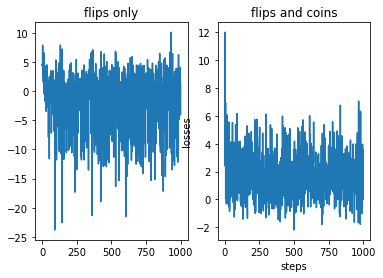

In [251]:
pyro.clear_param_store()
batch_size=3
steps = 1000
obs_flips, obs_coins = conditioned_coin_obs(None, None, batch_size, dbg=False)

adam_params = {"lr": 0.1, "betas": (0.9, 0.999)}
optimizer_adam = pyro.optim.Adam(adam_params)
optim_sgd = pyro.optim.SGD({"lr": 0.1, "momentum": 0.1})

pyro.clear_param_store()
losses0, a0, b0 = train(conditioned_coin_obs, coin_parametrized_guide,
                        obs_flips, None,
                        num_steps=steps, size=batch_size,
                        optimizer=optimizer_adam)
print(len(b0))
# is't last Nan?:
print("a0: ", a0[-1])
print("b0: ", b0[-1])

pyro.clear_param_store()
losses1, a1, b1 = train(conditioned_coin_obs, coin_parametrized_guide,
                        obs_flips, obs_coins,
                        num_steps=steps, size=batch_size,
                        optimizer=optimizer_adam)
print(len(b1))
# is't last Nan?:
print("a1: ", a1[-1])
print("b1: ", b1[-1])


# losses
fix, axs = plt.subplots(1, 2)
titles = ["flips only", "flips and coins"]
losses = [losses0, losses1]
for i, ax in enumerate(axs.flat):
    ax.plot(losses[i])
    ax.set_title(titles[i])
    plt.xlabel("steps")
    plt.ylabel("losses");
    
print("box_param_a: ", box_param_a)
print("box_param_b: ", box_param_b)
plt.show()
# print("losses:", loss)

Result:
only slight difference between certainty (smaller deviation if hso used)

### MCMC

In [90]:
box_param_a = 1
box_param_b = 5
# data = torch.zeros(10)
# data[0:6] = torch.ones(6)

# condition0
def conditioned_coin_obs_mcmc(obs_flips, obs_coins, a_errs, b_errs,
                              a_mean_errs, b_mean_errs, size=170, dbg=True):
    '''This condition is different from original
    in having aa and bb as samples. Since We do not use the guide
    here, need to tell mcmc to sample these as well'''
    
    # print("conditioned guess:",guess)
    # coin_param_dist = dist.Uniform(0.1, 0.9)
    # coin_param = coin_param_dist.sample()
    # print("coin param: ", coin_param)
    if dbg:
       print("\nfrom conditioned_coin_obs\n")
    
    aa = pyro.sample("a", dist.Uniform(0, 5))
    bb = pyro.sample("b", dist.Uniform(aa, 10))
    # print("guide a:", aa)
    a_errs.append(torch.abs(aa-box_param_a))
    b_errs.append(torch.abs(bb-box_param_b))
    if len(a_errs)%10==0:
        a_mean_errs.append(torch.mean(torch.tensor(a_errs)))
    if len(b_errs)%10==0:
        b_mean_errs.append(torch.mean(torch.tensor(b_errs)))
    # pyro.param("a_err", torch.abs(aa-box_param_a), torch.zeros(1))
    # pyro.param("b_err", torch.abs(bb-box_param_b), torch.zeros(1))
    
    
    coins=[]
    flips=[]
    # bug here with Uniform(0, 1)
    # coin = pyro.sample("coin", dist.Uniform(0, 2))
    # print("conditioned: coin: ", coin)
    # sample 10 times:
    with pyro.plate("data_loop", size=size) as ind:
        # no matter what, this value will be
        # replaced by the guide (get_trace(guide).nodes["coin"]["value"])
        box_dist = dist.Beta(aa, bb)
        box = pyro.sample("box", box_dist)

        if dbg:
            print("box", box)
            print("log box", box_dist.log_prob(box))
            # print("box_dist.batch_shape", box_dist.batch_shape)
            # print("coin_dist.batch_shape", coin_dist.batch_shape)
          
        coin_dist = dist.Beta(5, 10.*box)
        
        if obs_coins is not None:
            coin = pyro.sample("coin", coin_dist,
                               obs=obs_coins.index_select(0, ind))
        else:
            coin = pyro.sample("coin", coin_dist)
            coins.append(coin)
            if dbg:
                print("coin:", coin)
                print("coin log_prob:", coin_dist.log_prob(coin))
        
        flip_dist = dist.Bernoulli(probs=coin)
       
        if obs_flips is not None:
            flip = pyro.sample("flip", flip_dist,
                               obs=obs_flips.index_select(0, ind))
        else:
            flip = pyro.sample("flip", flip_dist)
            flips.append(flip)
            if dbg:
                print("flip:", flip)
                print("flip log_prob:", flip_dist.log_prob(flip))
        
    return(torch.cat(flips, 0) if flips != [] else None,
           torch.cat(coins, 0) if coins != [] else None)

In [91]:
class ResultCollectorMessenger(
        Messenger):
    def __init__(self, *args, **kwargs):
        self.a_errs = []
        self.b_errs = []
        
        Messenger.__init__(self, *args, **kwargs)
    
    def _pyro_post_param(self, msg):
        print("msg[name]", msg["name"])
        if msg["name"] == "a_err":
            self.a_errs.append(msg["value"])
        if msg["name"] == "b_err":
            self.b_errs.append(msg["value"])
    

In [92]:
def train(steps, obs_flips, obs_coins):
    nuts_kernel = NUTS(conditioned_coin_obs_mcmc)
    mcmc = MCMC(
            nuts_kernel,
            num_samples=steps,
            warmup_steps=1,
            num_chains=1,)

    # with ResultCollectorMessenger() as res:
    a_errs = []
    b_errs = []
    a_mean_errs = []
    b_mean_errs = []
    mcmc.run(obs_flips, None, a_errs, b_errs, a_mean_errs, b_mean_errs,
             size=len(obs_flips), dbg=False)
    print(mcmc.summary())
    return(mcmc, a_mean_errs, b_mean_errs)


Flips only:
(try several times if err is nan in the table)

In [94]:
pyro.clear_param_store()
obs_flips, obs_coins = conditioned_coin_obs(None, None, size=10, dbg=False)
pyro.clear_param_store()
mcmc, a_mean_errs, b_mean_errs = train(1000, obs_flips, None)

Sample: 100%|██████████| 1001/1001 [02:31,  6.59it/s, step size=5.00e-01, acc. prob=0.672]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      3.23      1.04      3.33      1.61      4.82    184.19      1.00
         b      7.08      1.62      7.09      4.24      9.33    379.18      1.00
    box[0]      0.28      0.16      0.26      0.01      0.52    327.72      1.00
    box[1]      0.29      0.15      0.28      0.04      0.51    475.27      1.00
    box[2]      0.29      0.16      0.27      0.03      0.51    359.84      1.00
    box[3]      0.30      0.16      0.28      0.03      0.53    503.62      1.00
    box[4]      0.35      0.16      0.33      0.09      0.60    594.23      1.00
    box[5]      0.36      0.16      0.35      0.14      0.65    624.51      1.00
    box[6]      0.29      0.16      0.27      0.04      0.52    425.16      1.00
    box[7]      0.35      0.15      0.33      0.09      0.59    827.09      1.00
    box[8]      0.36      0.16      0.34      0.12      0.63    529.58      1.00
    box[9]      0.29      0

Flips and coins

In [106]:
pyro.clear_param_store()
obs_flips, obs_coins = conditioned_coin_obs(None, None, size=10, dbg=False)
pyro.clear_param_store()
mcmc1, a_mean_errs1, b_mean_errs1 = train(1000, obs_flips, obs_coins)

Sample: 100%|██████████| 1001/1001 [05:29,  3.03it/s, step size=2.50e-01, acc. prob=0.905]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      2.91      1.13      2.84      1.12      4.64    158.76      1.01
         b      6.54      1.93      6.66      3.72      9.85    288.06      1.00
    box[0]      0.29      0.17      0.26      0.03      0.54    242.16      1.00
    box[1]      0.28      0.16      0.26      0.02      0.53    246.29      1.00
    box[2]      0.29      0.17      0.27      0.02      0.52    274.52      1.00
    box[3]      0.36      0.17      0.34      0.09      0.64    338.68      1.00
    box[4]      0.28      0.16      0.25      0.02      0.51    281.52      1.00
    box[5]      0.30      0.17      0.26      0.04      0.55    201.05      1.00
    box[6]      0.35      0.17      0.34      0.06      0.60    346.09      1.00
    box[7]      0.29      0.17      0.27      0.02      0.55    201.10      1.00
    box[8]      0.29      0.17      0.26      0.02      0.54    230.71      1.00
    box[9]      0.36      0

Errors:

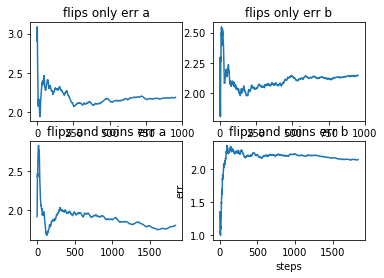

In [107]:
fix, axs = plt.subplots(2, 2)

axs.flat[0].plot(a_mean_errs)
axs.flat[0].set_title("flips only err a")
plt.xlabel("steps")
plt.ylabel("err");

axs.flat[1].plot(b_mean_errs)
axs.flat[1].set_title("flips only err b")
plt.xlabel("steps")
plt.ylabel("err");

axs.flat[2].plot(a_mean_errs1)
axs.flat[2].set_title("flips and coins err a")
plt.xlabel("steps")
plt.ylabel("err");

axs.flat[3].plot(b_mean_errs1)
axs.flat[3].set_title("flips and coins err b")

plt.xlabel("steps")
plt.ylabel("err");
plt.show()


Learned params

flips only mean a, b: (tensor(3.2511), tensor(7.0608))
flips and coins mean a, b: (tensor(2.9042), tensor(6.5357))


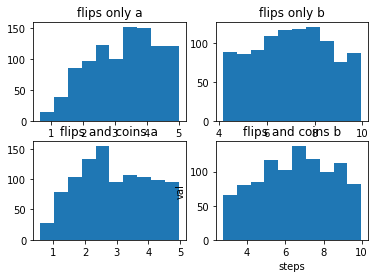

In [110]:
learned_params = mcmc.get_samples(1000)
a, b = torch.mean(learned_params['a']), torch.mean(learned_params["b"])
print("flips only mean a, b:", (a, b))
fix, axs = plt.subplots(2, 2)

axs.flat[0].hist(learned_params['a'])
axs.flat[0].set_title("flips only a")
axs.flat[1].hist(learned_params['b'])
axs.flat[1].set_title("flips only b")

learned_params1 = mcmc1.get_samples(1000)
a1, b1 = torch.mean(learned_params1['a']), torch.mean(learned_params1["b"])
print("flips and coins mean a, b:", (a1, b1))

axs.flat[2].hist(learned_params1['a'])
axs.flat[2].set_title("flips and coins a")
axs.flat[3].hist(learned_params1['b'])
axs.flat[3].set_title("flips and coins b")

plt.xlabel("steps")
plt.ylabel("val");
plt.show()


In [35]:
mcmc.run(obs_flips, None, size=3, dbg=False)
# mcmc.get_samples(3)
mcmc.diagnostics()

Sample: 100%|██████████| 31/31 [00:04,  7.52it/s, step size=2.50e-01, acc. prob=0.804]


{'a': OrderedDict([('n_eff', tensor(12.4988)), ('r_hat', tensor(1.0629))]),
 'acceptance rate': {'chain 0': 0.9},
 'b': OrderedDict([('n_eff', tensor(12.4975)), ('r_hat', tensor(1.0061))]),
 'box': OrderedDict([('n_eff', tensor([22.2128, 10.5437, 12.3828])),
              ('r_hat', tensor([0.9681, 1.0462, 1.0605]))]),
 'coin': OrderedDict([('n_eff', tensor([17.8065, 15.7111, 40.1744])),
              ('r_hat', tensor([1.0270, 1.0304, 1.0602]))]),
 'divergences': {'chain 0': [1,
   4,
   5,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   16,
   19,
   21,
   22,
   23,
   24,
   25,
   29]}}

In [ ]:
def train_mcmc(model, obs_flips, obs_coins, num_steps=500, size=3):
    # setup the optimizer:
    
    loss = pyro.infer.Trace_ELBO()
    # optimizer.zero_grad()
    pyro.clear_param_store()

    nuts_kernel = NUTS(model)
    mcmc = MCMC(
        nuts_kernel,
        num_samples=num_samples,
        warmup_steps=warmup_steps,
        num_chains=num_chains,
    )
    mcmc.run(model, obs_flips, None, size=size)
    mcmc.summary(prob=0.5)
    
    losses, a,b  = [], [], []
    
    return losses, a, b


In [40]:
def coin_parametrized_guide1(obs_flips, obs_coins=None, size=None):
   
    # bug here with interval(0, 1)
    aa = pyro.param("a", torch.tensor(0.4),
                    constraint=constraints.interval(0, 0.9))
    bb = pyro.param("b", torch.tensor(0.6),
                    constraint=constraints.interval(0, 0.9))
    # print("guide a:", aa)
    
    '''
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0),
                         constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0),
                        constraint=constraints.positive)
    '''
    # print("guide alpha_q:", alpha_q)
    # print("guide beta_q:", beta_q)
    
    res = pyro.sample("coin", dist.Uniform(aa, bb))
    # print("guide: coin", res)
    return res
    # return pyro.sample("coin", dist.Beta(alpha_q, beta_q))

In [76]:
coin_parametrized_guide(obs_coin_flips, obs_coins=None, size=31)

tensor([0.2286, 0.1531, 0.1919, 0.1603, 0.3439, 0.2400, 0.1886, 0.1302, 0.2936,
        0.2177, 0.2725, 0.1576, 0.1611, 0.2333, 0.3100, 0.3090, 0.1396, 0.1547,
        0.3365, 0.1380, 0.1743, 0.3339, 0.1514, 0.3918, 0.1318, 0.2860, 0.2373,
        0.2668, 0.3320, 0.1960, 0.3642], grad_fn=<AddBackward0>)

In [77]:
import matplotlib.pyplot as plt
# coin_parametrized_guide1(data)

In [78]:
def train(obs_flips, obs_coins=None, size=170, num_steps=500):
    guess = 8.5
    LEARNING_RATE = 1.0e-7
    
    # setup the optimizer:
    adam_params = {"lr": 0.05, "betas": (0.9, 0.999)}
    optimizer = pyro.optim.Adam(adam_params)

    # adam_params = {"lr": 0.00000000000005, "betas": (0.998, 0.999)}
    # optimizer = pyro.optim.Adam(adam_args)

    # adam_args = {"lr": LEARNING_RATE}
    # optimizer = pyro.optim.Adam(adam_args)
    # optimizer = pyro.optim.Adam({"lr": 0.00000000001, "betas": (0.95, 0.999)})
    # optimizer=pyro.optim.SGD({"lr": 0.01,
    #                         "momentum":0.9})

    # setup the loss:
    # loss = pyro.infer.CSIS()
    # loss = pyro.infer.TraceEnum_ELBO()
    loss = pyro.infer.Trace_ELBO()
    # optimizer.zero_grad()
    pyro.clear_param_store()


    svi = pyro.infer.SVI(model=conditioned_coin_obs,
                         guide=coin_parametrized_guide,
                         # guide=coin_parametrized_guide,
                         optim=optimizer,
                         loss=loss)


    losses, a,b  = [], [], []
    # num_steps = 500  # 2500
    for t in range(num_steps):
        # import pdb; pdb.set_trace()
        losses.append(svi.step(obs_flips, obs_coins, size=size))
        # a.append(pyro.param("a").item())
        b.append(pyro.param("b").item())
        # print(pyro.param("a").grad)
    return losses, a, b

Preparing data:

In [94]:
# data = torch.tensor([coin_model0(1) for i in range(10)])
# data
size = 100
num_steps = 100 # 700
obs_coins, obs_coin_flips = coin_model0(size=num_steps)
# obs_coin_flips
# obs_coins

Only one lavel obs available 

100
b:  0.5310731530189514
b =  0.5310731530189514


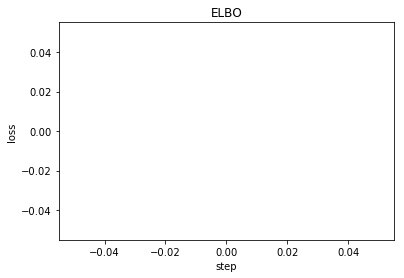

losses: [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]


In [96]:
losses0, a0, b0 = train(obs_coin_flips, size=size, num_steps=num_steps) 
print(len(b0))
# is't last Nan?:
# print("a: ", a0[-1])
print("b: ", b0[-1])
# losses
plt.plot(losses0)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('b = ',pyro.param("b").item())
plt.show()
print("losses:", losses0)

0
b:  0.7958372235298157
b =  0.7958372235298157


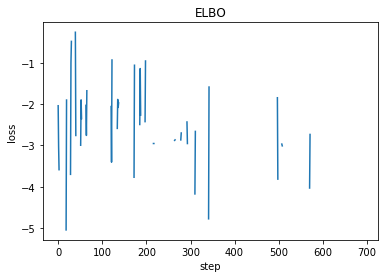

In [16]:
losses1, a1, b1 = train(obs_coin_flips, obs_coins=obs_coins, size=size, num_steps=num_steps) 
print(len(a1))
# is't last Nan?:
# print("a: ", a1[-1])
print("b: ", b1[-1])
# losses
plt.plot(losses1)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('b = ',pyro.param("b").item())
plt.show()

In [79]:
def model1(obs, n):
    # p_a = torch.tensor(0.7)
    p_a = torch.tensor([7, 3, 10])
    p_b = torch.tensor([0.1, 0.3, 0.6])
                     
    with pyro.plate("plate1", n):
        a = pyro.sample("a", dist.Categorical(p_a))
        # a = pyro.sample("a", dist.Binomial(2, p_a))
        print("a")
        print(a)
        idx = Vindex(p_b)[a.type(torch.long)]
        d = dist.Bernoulli(idx)
        print("idx")
        print(idx)
        # log_p will still work correctly in this case because it
        # use d.log_p, and d has probability p_b[a]
        # so p(b=0, a=1) = p(b=0|a=1)*p(a=1) = 0.7*(2*p*(1-p))
        # = 0.7*2*0.5*0.5 = 0.7*0.5 = 0.35
        b = pyro.sample("b", d)
    
    # cdist = pdist.
    return b


In [80]:
model1(None, 7)

a
tensor([2, 1, 0, 0, 2, 0, 2])
idx
tensor([0.6000, 0.3000, 0.1000, 0.1000, 0.6000, 0.1000, 0.6000])


tensor([0., 1., 0., 0., 0., 0., 1.])

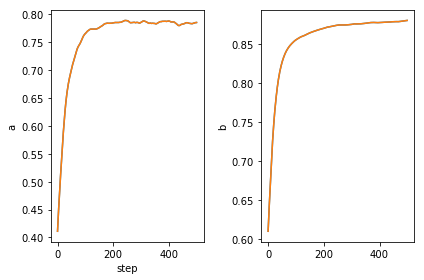

In [14]:
plt.subplot(1,2,1)
# plt.plot([0,num_steps],[9.14,9.14], 'k:')
plt.plot(a)
plt.xlabel("step")
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
# plt.plot([0,num_steps],[0.6,0.6], 'k:')
plt.plot(b)
plt.tight_layout()
plt.show()

In [139]:
p


tensor(0.7340, grad_fn=<AddBackward0>)

In [136]:
p = pyro.param('a')
print(p.item())
p.unbind?

print(a.item())
print(p.item())


0.7339773774147034
0.7339773774147034
0.7339773774147034


##### Appendix:

In [17]:
loss = pyro.infer.Trace_ELBO()
model_trace, guide_trace = loss._get_trace(conditioned_coin_obs,
                                           coin_parametrized_guide,
                                           [data],{})
model_trace.nodes.items()
for name, site in guide_trace.nodes.items():
    if site["type"] == "sample":
        print(name)
        print(site['score_parts'])


coin
ScoreParts(log_prob=tensor(-0.5108, grad_fn=<NegBackward>), score_function=tensor(-0.5108, grad_fn=<NegBackward>), entropy_term=0)


In [18]:
import pyro.poutine as poutine

In [19]:
# strange behaviour of values (bug?):
with poutine.trace(param_only=True) as param_capture:
    
    loss.loss_and_grads(conditioned_coin_obs, coin_parametrized_guide,[data])
params = set(site["value"].unconstrained()
             for site in param_capture.trace.nodes.values())

params

ValueError: Error while computing log_prob at site 'flip':
Input arguments must all be instances of numbers.Number or torch.tensor.
Trace Shapes:     
 Param Sites:     
Sample Sites:     
    coin dist    |
        value    |
     log_prob    |
    flip dist 10 |
        value    |

In [21]:
# leaf tensor?:
adam_params = {"lr": 0.0005, "betas": (0.9, 0.999)}
optimizer = pyro.optim.Adam(adam_params)
optimizer([pyro.param('a')])

ValueError: can't optimize a non-leaf Tensor